In [ ]:
# @title Config
image_shape = (256, 256, 3)
latent_shape = (32,32,4)
batch_size = 32
filters = [64,128,256]
z_channels = 4
depth = 2

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install opencv-python
!pip install kagglehub

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/ubuntu/.cache/kagglehub/datasets/nagasai524/mini-coco2014-dataset-for-image-captioning/versions/1


In [ ]:
import torch
from torchvision.models import vgg16, VGG16_Weights
import gc
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import time
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
from pathlib import Path

path = ""

In [ ]:
import kagglehub

image_path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

print("Path to dataset files:", path)

In [ ]:
data = []

for dirpath, _, filenames in os.walk(image_path):
  for filename in filenames:
    if filename.endswith("jpg"):
      name = os.path.join(dirpath, filename)
      img = cv2.imread(name)
      img = cv2.resize(img, (image_shape[0],image_shape[0]))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      latent = np.array([img/127.5 - 1])
      data.append(latent)

print(len(data)) # 163957

In [ ]:
# @title Dataset
class CustomDataset(Dataset):
  def __init__(self, data):
    self.indices = np.arange(len(data))
    np.random.shuffle(self.indices)
    self.data = data

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, idx):
    return torch.tensor(self.data[self.indices[idx]][0], dtype=torch.float32)
plt.imshow(CustomDataset(data)[0]/2+0.5)

In [ ]:
# @title ResAttn
class SpatialAttention(nn.Module):
  def __init__(self, in_c):
    super().__init__()
    self.norm = nn.GroupNorm(num_groups=32, num_channels=in_c, eps=1e-6, affine=True)
    self.Q = nn.Conv2d(in_c, in_c, kernel_size=1, stride=1, padding=0)
    self.K = nn.Conv2d(in_c, in_c, kernel_size=1, stride=1, padding=0)
    self.V = nn.Conv2d(in_c, in_c, kernel_size=1, stride=1, padding=0)
    self.proj = nn.Conv2d(in_c, in_c, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    b, c, h, w = x.shape
    R = self.norm(x)
    q, v, k = self.Q(R), self.V(R), self.K(R)
    q, v, k = q.reshape(b, c, h*w), v.reshape(b, c, h*w), k.reshape(b, c, h*w)
    q, v, k = q.permute(0, 2, 1), v, k
    R = torch.bmm(q, k)
    R = F.softmax(R, dim=2)
    R = torch.bmm(v, R)
    R = R.permute(0, 2, 1)
    R = R.reshape(b, c, h, w)
    return self.proj(R) + x

class ResBlock(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.reshape = False
    if in_c != out_c:
      self.reshape = True
      self.conv_reshape = nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1)
    self.norm1 = nn.GroupNorm(num_groups=32, num_channels=out_c, eps=1e-6, affine=True)
    self.conv1 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1)
    self.norm2 = nn.GroupNorm(num_groups=32, num_channels=out_c, eps=1e-6, affine=True)
    self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    if self.reshape:
      x = self.conv_reshape(x)
    res = x
    x = self.norm1(x)
    x = x * torch.sigmoid(x)
    x = self.conv1(x)
    x = self.norm2(x)
    x = x * torch.sigmoid(x)
    x = self.conv2(x)
    x = x + res
    return x

In [ ]:
# @title VAE
class Encoder(nn.Module):
  def __init__(self, img_shape, filters, attn_resolutions, z_channels, depth):
    super().__init__()
    self.z_channels = z_channels
    self.out_shape = (z_channels, img_shape[1] // 2**len(filters), img_shape[2] // 2**len(filters))
    self.conv_out = nn.Conv2d(filters[-1], z_channels, kernel_size=3, stride=1, padding=1)

    self.prep = nn.Conv2d(img_shape[0], filters[0], kernel_size=3, stride=2, padding=1)
    self.down = nn.ModuleList()

    current_res = img_shape[-1]
    for i in range(len(filters)-1):
      current_res = current_res // 2
      block = nn.ModuleList([ResBlock(filters[i], filters[i+1])])
      for _ in range(depth-1):
        block.append(ResBlock(filters[i+1], filters[i+1]))
      if current_res in attn_resolutions:
        block.append(SpatialAttention(filters[i+1]))
      block.append(nn.Conv2d(filters[i+1], filters[i+1], kernel_size=3, stride=2, padding=1))
      self.down.append(block)

    self.mid = nn.Sequential(ResBlock(filters[-1], filters[-1]),
                            SpatialAttention(filters[-1]),
                            ResBlock(filters[-1], filters[-1]))

    self.norm = nn.GroupNorm(num_groups=32, num_channels=filters[-1], eps=1e-6, affine=True)

  def forward(self, x):
    x = x.permute(0,3,1,2)
    x = self.prep(x)
    for block in self.down:
      for layer in block:
        x = layer(x)
    x = self.mid(x)
    x = self.norm(x)
    x = self.conv_out(x)
    return x

class Decoder(nn.Module):
  def __init__(self, latent_shape, filters, attn_resolutions, depth):
    super().__init__()
    self.out_shape = (3, latent_shape[1]*2**len(filters), latent_shape[2]*2**len(filters))
    self.conv_in = nn.Conv2d(latent_shape[0], filters[0], kernel_size=3, stride=1, padding=1)
    self.mid = nn.Sequential(ResBlock(filters[0], filters[0]),
                            SpatialAttention(filters[0]),
                            SpatialAttention(filters[0]),
                            ResBlock(filters[0], filters[0]))

    self.up = nn.ModuleList()
    current_res = latent_shape[-1]
    for i in range(len(filters)-1):
      current_res = current_res * 2
      block = nn.ModuleList([ResBlock(filters[i], filters[i+1])])
      for _ in range(depth-1):
        block.append(ResBlock(filters[i+1], filters[i+1]))
      if current_res in attn_resolutions:
        block.append(SpatialAttention(filters[i+1]))
        block.append(SpatialAttention(filters[i+1]))
      block.append(nn.Upsample(scale_factor=2, mode="bilinear"))
      self.up.append(block)

    self.norm = nn.GroupNorm(num_groups=32, num_channels=filters[-1], eps=1e-6, affine=True)
    self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
    self.conv_out = nn.Conv2d(filters[-1], 3, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    x = self.conv_in(x)
    x = self.mid(x)
    for block in self.up:
      for layer in block:
        x = layer(x)
    x = self.norm(x)
    x = self.upsample(x)
    x = self.conv_out(x)
    x = F.tanh(x)
    x = x.permute(0,2,3,1)
    return x

In [ ]:
# @title Discriminator + Perceptual
class Discriminator(nn.Module):
  def __init__(self, img_shape, filters=[256,512]):
    super().__init__()
    module_list = [nn.Conv2d(img_shape[0], filters[0], kernel_size=3, stride=2, padding=1),
                   nn.BatchNorm2d(filters[0]),
                   nn.LeakyReLU(0.2)]
    for i in range(1,len(filters)):
      module_list += [nn.Conv2d(filters[i-1], filters[i], kernel_size=3, stride=2, padding=1),
                      nn.BatchNorm2d(filters[i]),
                      nn.LeakyReLU(0.2)]

    self.convs = nn.Sequential(*module_list)
    self.mlp = nn.Sequential(nn.Conv2d(filters[-1], 1, kernel_size=1, stride=1, padding=0))

  def forward(self, x):
    x = x.permute(0,3,1,2)
    x = self.convs(x)
    x = self.mlp(x)
    return x

class vgg_builder(nn.Module):
  def __init__(self):
    super(vgg_builder, self).__init__()
    convs = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features
    self.N_slices = 5
    self.slices = nn.ModuleList(list(nn.Sequential() for _ in range(self.N_slices)))
    for x in range(4):
      self.slices[0].add_module(str(x), convs[x])
    for x in range(4, 9):
      self.slices[1].add_module(str(x), convs[x])
    for x in range(9, 16):
      self.slices[2].add_module(str(x), convs[x])
    for x in range(16, 23):
      self.slices[3].add_module(str(x), convs[x])
    for x in range(23, 30):
      self.slices[4].add_module(str(x), convs[x])
    for param in self.parameters():
      param.requires_grad = False

  def forward(self, x):
    feat_map = []
    x = self.slices[0](x)
    feat_map.append(x)
    x = self.slices[1](x)
    feat_map.append(x)
    x = self.slices[2](x)
    feat_map.append(x)
    x = self.slices[3](x)
    feat_map.append(x)
    x = self.slices[4](x)
    feat_map.append(x)
    return feat_map

In [ ]:
encoder = Encoder((3,256,256), [64,128,256], {}, 4, 2)
decoder = Decoder((4,32,32), [64,128,256], {}, 2)
D = Discriminator((3,256,256))

vgg = vgg_builder()
for param in vgg.parameters():
    param.requires_grad = False

#encoder.load_state_dict(torch.load(path + f"safe_tensors_depth2_256/encoder3.pt", map_location=torch.device('cuda')))
#decoder.load_state_dict(torch.load(path + f"safe_tensors_depth2_256/decoder3.pt",map_location=torch.device('cuda')))
#D.load_state_dict(torch.load(path + f"safe_tensors_depth2_256/discriminator3.pt",map_location=torch.device('cuda')))

print(f"encoder: {sum(p.numel() for p in encoder.parameters())/(262144):.3f}MB")
print(f"decoder: {sum(p.numel() for p in decoder.parameters())/(262144):.3f}MB")
print(f"Discriminator: {sum(p.numel() for p in D.parameters())/(262144):.3f}MB")
print(f"VGG: {sum(p.numel() for p in vgg.parameters())/(262144):.3f}MB")

In [ ]:
# @title Training Configurations
class Trainer():
  def __init__(self, encoder, decoder, D, vgg, losses, data_len, ema=3, a_disc=1, a_vae=1, a_KL=0.05):
    self.vgg_schedule = None
    self.ema = 2/(ema+1)
    self.a_disc = a_disc
    self.a_vae = a_vae
    self.a_KL = a_KL

    self.encoder = encoder
    self.decoder = decoder
    self.D = D
    self.vgg = vgg
    self.encoder_optimizer = torch.optim.Adam(self.encoder.parameters(),  lr=1e-4)
    self.encoder_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.encoder_optimizer, T_max=50)
    self.decoder_optimizer = torch.optim.Adam(self.decoder.parameters(),  lr=1e-4)
    self.decoder_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.decoder_optimizer, T_max=50)
    self.D_optimizer = torch.optim.Adam(self.D.parameters(),  lr=1e-4)
    self.D_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.D_optimizer, T_max=50)
    self.losses = losses
    self.loss_vals = {loss:0 for loss in losses}
    self.data_len = data_len
    self.loss_record = []
    self.epoch = 1
    self.index = 1
    self.device = torch.device("cuda")

    self.encoder.to(self.device)
    self.decoder.to(self.device)
    self.D.to(self.device)
    self.vgg.to(self.device)

  def train_step(self, x, with_mse=True, freeze_ae=False, freeze_disc=False):
    self.index += 1
    x = x.to(self.device)
    with torch.no_grad():
      x_hat = self.decoder(self.encoder(x))
    disc_loss = F.relu(1. - self.D(x)).mean() + F.relu(1. + self.D(x_hat)).mean() # Hinge
    self.D_optimizer.zero_grad()
    disc_loss.backward()
    self.D_optimizer.step()
    self.D_scheduler.step()

    if not freeze_ae:
      z = self.encoder(x)
      x_hat = self.decoder(z)
      mse = F.mse_loss(x_hat, x)
      KL = 0.5 * (z.mean() ** 2)
      vgg_real = self.vgg(torch.permute(x, (0,3,1,2)))
      vgg_fake = self.vgg(torch.permute(x_hat, (0,3,1,2)))
      vgg_loss = 0
      for i in range(len(vgg_real)):
        vgg_loss += F.mse_loss(vgg_real[i], vgg_fake[i]) # * self.vgg_schedule[i]

      adv_loss = 0
      if not freeze_disc:
        adv_loss = -(self.D(self.decoder(self.encoder(x))).mean())

      loss = mse * with_mse + self.a_KL* KL + vgg_loss + self.a_vae * adv_loss
      self.encoder_optimizer.zero_grad()
      self.decoder_optimizer.zero_grad()
      loss.backward()
      self.encoder_optimizer.step()
      self.decoder_optimizer.step()
      self.encoder_scheduler.step()
      self.decoder_scheduler.step()

    self.update_batch({"mse":mse.item() if not freeze_ae else 0, "gan":disc_loss.item(), "vgg":vgg_loss.item() if not freeze_ae else 0})

  def update_batch(self, loss_vals):
    clear_output(wait=True)
    for record in self.loss_record:
      print(record)
    self.loss_vals = {loss:(1-self.ema)*self.loss_vals[loss] + self.ema*loss_vals[loss] for loss in self.losses}
    print(f"epoch:{self.epoch} ", end="")
    for loss in self.losses:
      print(f"{loss}: {self.loss_vals[loss]:.3f} ", end="")
    for _ in range(int(self.index * 10 / self.data_len)):
      print("=", end="")
    for _ in range(int(self.index * 10 / self.data_len),10):
      print("-", end="")

  def update_epoch(self):
    self.index = 0
    record = f"epoch:{self.epoch} "
    for loss in self.losses:
      record += f"{loss}: {self.loss_vals[loss]:.3f} "
    self.loss_record.append(record)
    self.epoch += 1

epoch:1 mse: 0.120 KL: 0.027 gan: 0.425 a vae: 0.020 a disc: 0.605 
epoch:2 mse: 0.153 KL: 0.025 gan: 1.184 a vae: 0.006 a disc: 0.497 
epoch:3 mse: 0.115 KL: 0.034 gan: 0.360 a vae: 0.018 a disc: 0.614 
epoch:4 mse: 0.120 KL: 0.034 gan: 0.551 a vae: 0.003 a disc: 0.576 ==========

In [ ]:
# @title Setup Training
dataset   = CustomDataset(data)
loader    = DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)
epochs = 5
trainer = Trainer(encoder, decoder, D, vgg, ["mse", "gan", "vgg"], len(loader))

In [ ]:
for epoch in range(1, epochs):
  index = 0
  for i, x in enumerate(loader):
    trainer.train_step(x, with_mse=False, freeze_disc=(epoch==1 and i < 50000/batch_size))
  trainer.update_epoch()

<All keys matched successfully>

(1, 512, 512, 3)


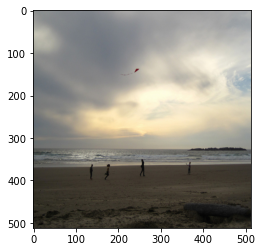

In [ ]:
torch.save(encoder.state_dict(), path + f"encoder.pt")
torch.save(decoder.state_dict(), path + f"decoder.pt")
torch.save(D.state_dict(), path + f"discriminator.pt")

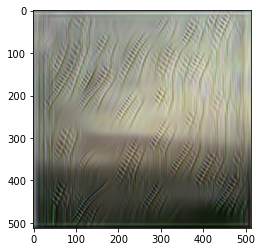

In [ ]:
del trainer
del encoder
del decoder
del D
torch.cuda.empty_cache()
gc.collect()

In [ ]:
x = np.array(data[np.random.randint(0,len(data))][0])
plt.imshow(x[0]/2+0.5)

In [ ]:
x = torch.tensor(x, dtype=torch.float32).to(torch.device("cuda"))# if torch.cuda.is_available() else torch.tensor(x, dtype=torch.float32).to(torch.device("cpu"))
z = encoder(x)[:,:encoder.z_channels,:]
x_hat = decoder(z).cpu().detach().numpy()
print(z.shape)
plt.imshow(x_hat[0]/2+0.5)

In [ ]:
from PIL import Image
import requests
from io import BytesIO

url = "https://www.famousbirthdays.com/faces/notyouraverageflight-image.jpg"
resp = requests.get(url)
img = Image.open(BytesIO(resp.content))
#img = more_imgs[np.random.randint(0,8000)]
img = np.array(img)
img = cv2.resize(img, (256, 256))
plt.imshow(img)
x = np.expand_dims(img/127.5 - 1,0)